In [ ]:
pip install numpy pandas nltk scikit-learn

In [ ]:
import pandas as pd
import string
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

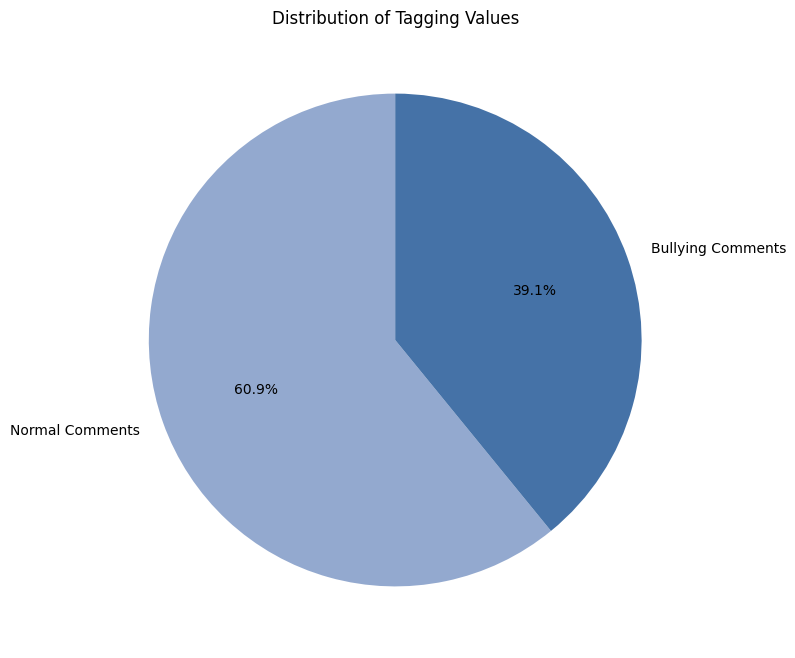

In [ ]:
# Load the dataset
df = pd.read_csv('Suspicious Communication on Social Platforms.csv')

# Count the occurrences of each value in the 'tagging' column
tagging_counts = df['tagging'].value_counts()

# Define RGBA colors for Normal Comments (0) and Bullying Comments (1)
colors = [(147/255, 169/255, 207/255, 1), (69/255, 114/255, 167/255, 1)]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(tagging_counts, labels=['Normal Comments', 'Bullying Comments'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Tagging Values')
plt.show()


In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

stopwords_set = set(stopwords.words('english'))
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def tokenize_remove_punctuations(text):
    clean_text = []
    text = text.split(" ")
    for word in text:
        word = list(word)
        new_word = []
        for c in word:
            if c not in string.punctuation:
                new_word.append(c)
        word = "".join(new_word)
        if len(word) > 0:
            clean_text.append(word)
    return clean_text

def stemming(text):
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word not in stopwords_set:
            clean_text.append(word)
    return clean_text

def pos_tagging(text):
    tagged = nltk.pos_tag(text)
    return tagged

def get_wordnet(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(pos_tags):
    lemmatized_text = []
    for t in pos_tags:
        word = WordNetLemmatizer().lemmatize(t[0], get_wordnet(t[1]))
        lemmatized_text.append(word)
    return lemmatized_text

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = tokenize_remove_punctuations(text)
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = stemming(text)
    text = remove_stopwords(text)
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tagging(text)
    text = lemmatize(pos_tags)
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return text


# Preprocess the text
df['clean_comment'] = df['comments'].apply(clean_text)

# Train models
max_features = 10000

vectorizer = TfidfVectorizer(max_features=max_features)
X_vectorized = vectorizer.fit_transform(df['clean_comment'])
y = df['tagging']

# Load the trained models
models = {
    'Linear SVC': LinearSVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'MLP': MLPClassifier(),
}

# Train and save models
for model_name, model in models.items():
    model.fit(X_vectorized, y)
    # Save the trained model using pickle
    with open(f'{model_name}_model.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Prediction
comment_input = input("Enter your comment here:")
clean_comment_input = clean_text(comment_input)

for model_name, model in models.items():
    comment_vectorized = vectorizer.transform([clean_comment_input])
    prediction = model.predict(comment_vectorized)
    print(f"Prediction for {model_name}: {'Bullying comment' if prediction[0] == 1 else 'Normal comment'}")


Enter your comment here:damn your evil 60 minute IPA beckoning me from the fridge right now...
Prediction for Linear SVC: Bullying comment
Prediction for Logistic Regression: Bullying comment
Prediction for Random Forest: Bullying comment
Prediction for MLP: Bullying comment


In [ ]:
results=[]

# Train and save models
for model_name, model in models.items():
    # Calculate and store performance metrics
    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['tagging'], test_size=0.3, random_state=42)
    X_test_vectorized = vectorizer.transform(X_test)
    y_pred = model.predict(X_test_vectorized)

    # Display performance metrics for all models
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Display performance metrics for all models
df_results = pd.DataFrame(results)
df_results.set_index('Model', inplace=True)

print("\nPerformance Metrics for All Models:")
print(df_results)

# Plotting graphs
fig1 = go.Figure()

for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    fig1.add_trace(go.Bar(x=df_results.index, y=df_results[metric], name=metric))

fig1.update_layout(barmode='group', title="Performance Metrics for All Models", xaxis_title="Model", yaxis_title="Score")
fig1.show()

fig = go.Figure()

for model_name, model in models.items():
    # ROC curve
    if hasattr(model, "decision_function"):
      decision_function = model.decision_function(X_test_vectorized)
      fpr, tpr, _ = roc_curve(y_test, decision_function)
    else:
      y_scores = model.predict_proba(X_test_vectorized)[:, 1]
      fpr, tpr, _ = roc_curve(y_test, y_scores)

    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{model_name} ROC Curve'))

fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curves',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    legend_title='Models'
)

fig.show()


Performance Metrics for All Models:
                     Accuracy  Precision    Recall  F1 Score
Model                                                       
Linear SVC           0.949842   0.921992  0.951606  0.936565
Logistic Regression  0.856524   0.849620  0.767024  0.806212
Random Forest        0.993834   0.988936  0.995289  0.992102
MLP                  0.964339   0.942797  0.967024  0.954757
